# Homework 3

DUE DEC 1st at 11:59 PM

Matthew Xu 
5752811


In [2]:
import torch
from torch.autograd import Variable
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Problem 1

In this problem, you will implement a simple feed-forward neural network using PyTorch, a straight-forward and simple-to-pickup framework for quickly prototyping deep learning model. 

PyTorch provides 2 powerful things. First, a nice data structure called Tensor (basically a matrix, similar to Numpy ndarray). Tensor is optimized for matrix calculation and can be loaded to a GPU. Tensor is also implemented so that it's easy to calculate and pass back chains of gradients, which is extremely useful for backpropagation on neural network. Second, a nice inner mechanism called Autograd that nicely map variables involved a chain of calculations and efficiently calculate their gradients via the chain rule when needed. Read more here: https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95  

You will train and evaluate the model on a simple dataset for classifying seeds. The dataset has 7 features and 3 labels. Refer to the example from the discussion session if needed. 

**In this problem, you are given a good amount of freedom in tweaking your choices in designing the network. As long as it's still a feed-forward network, it's fine. Accuracy does not matter as long as it's reasonable (like above 80%) but do try to achieve a high accuracy.**

(Optional): the dataset provided to you is very simple. Instead, you can challenge yourself by trying more difficult datasets. Some datasets that you can loaded directly using PyTorch:
- MNIST (Most famous dataset for getting into Deep Learning)
- Fashion-MNIST
- Kuzushiji-MNIST 

The datasets are available at https://pytorch.org/docs/stable/torchvision/datasets.html. You will get the same grade no matter what dataset you use. 

### Part a
Firstly, load and inspect the dataset from "seeds_dataset.csv". Split them into a train set (90%) and a test set (10%). You should be quite comfortable with these operations by now. 

In [18]:
#split data train = 90%
data = pd.read_csv('seeds_dataset.csv')
X = data.iloc[:,:-1].to_numpy(dtype=np.float32)
y = data.iloc[:,-1].to_numpy(dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Part b 
Create a Python class for our neural network model. The network should have 1 input layer, at least 1 hidden layer, and 1 output layer. You are free to choose the size and the number of hidden layers (it may affect the performance so try tweaking around a bit), and the activation function (or no activation at all).

Some popular activation functions that you can try:
- Sigmoid (torch.sigmoid)
- ReLU (torch.relu)
- Tanh (torch.tanh)

In [22]:
#front forward network
#in features equals original number of features

class network(torch.nn.Module):
    
    def __init__(self):
        super(network,self).__init__()
        self.layer1 = torch.nn.Linear(in_features=7, out_features=40)
        self.layer2 = torch.nn.Linear(in_features=40, out_features=40)
        self.outputlayer = torch.nn.Linear(in_features=40, out_features=10)
        
    def forward(self,x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.outputlayer(x)
        
        return x

### Part c 
Train the network using the train dataset. You are free to choose any suitable optimizer and loss function provided by PyTorch (or you can just use SGD optimizer and CrossEntropyLoss like we did in the discussion session for simplicity). After each epoch, record the current loss and the current accuracy. The current accuracy is obtained by evaluating the model on the train dataset. 

Some optimizers that you can try:
- SGD
- Adagrad
- Adam

https://pytorch.org/docs/stable/optim.html

In [23]:
epochs = 20
learning_rate = 0.01
batch_size = 32

# Create the neural network
network = network()
# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate) # Named SGD but actually mini-batch Gradient Descent

# Set network to train
network.train()

training_size = len(X_train)
num_batches = math.ceil(training_size/batch_size)

#arrays for loss and accuracy values
hold_loss = []
hold_accuracy = []

for epoch in range(epochs):
    
    X_train, y_train = shuffle(X_train, y_train)
    network.eval()
    
    pred_train = torch.argmax(network(torch.tensor(X_train).float()), dim=1).numpy()
    
    for batch in range(num_batches):
        
        X_train_batch = torch.tensor(X_train[batch*batch_size:min(batch*batch_size+batch_size,training_size),:])
        y_train_batch = torch.tensor(y_train[batch*batch_size:min(batch*batch_size+batch_size,training_size)], dtype=torch.long)
        
        optimizer.zero_grad()
        
        output = network(X_train_batch)
        
        loss = criterion(output,y_train_batch)
        loss.backward()
        
        optimizer.step()
        

    hold_loss.append(loss.item())
    hold_accuracy.append(np.sum(pred_train == y_train)/len(y_train))

Plot how the loss and the accuracy change over the epochs. 

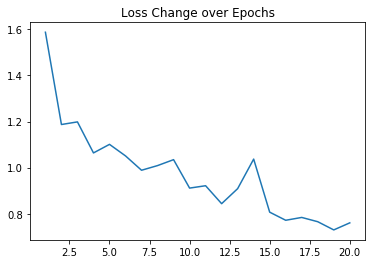

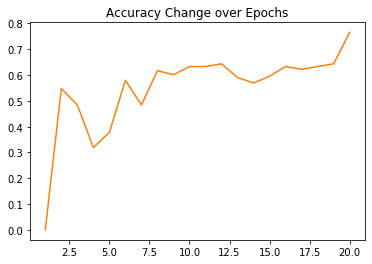

In [24]:
x_axis = np.linspace(1, epochs, num=epochs)

plt.subplots()
plt.plot(x_axis, hold_loss)
plt.title('Loss Change over Epochs')

plt.subplots()
plt.plot(x_axis, hold_accuracy, 'C1')
plt.title('Accuracy Change over Epochs')
plt.show()

### Part d 
Evaluate the model on the test dataset. Print out the accuracy. Does this accuracy agrees with the training accuracy showed on the plot? Why may they be different?

In [237]:
network.eval()
pred_test = torch.argmax(network(torch.tensor(X_test).float()), dim=1).numpy()
print("Accuracy: ", np.sum(pred_test == y_test)/len(y_test))

Accuracy:  0.8571428571428571


This accuracy evaluated from the test dataset matches the training accuracy. In the training accuracy, as epochs increases, the accuracy appears to converge to 0.9. The accuracy above is similar at 0.85. There might be some differences due to the size of datasets and therefore, having less comparisons for accuracy (y_train is of size 189 and y_test is of size 21)

## Problem 2

If you haven't done so already, please read Chapter 2 (on fairness) of the textbook.

### Part a

Import the 'semi_synthetic.csv' dataset. This dataset is a modified version of the UCI Credit card dataset (details [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)). We added a new synthetic feature to this dataset called `LIMIT_BAL`. It is highly predictive for `SEX==2` but not at all for `SEX==1`. As it turns out, this causes issues with fairness where models rely too much on `LIMIT_BAL` and discriminate against `SEX==2`. We will try to mitigate this in terms of the fairness criterion 'Statistical Parity' as it's mentioned in the textbook.

In [4]:
import pandas as pd

data_semi = pd.read_csv('semi_synthetic.csv', header = 0)


Extract features from the dataset (all columns except last) and call it `X`. Extract last column and call it `Y`. Also extract the `SEX` column and call this `SF` (for sensitive feature). Split all of these arrays data into train and test sets. You can use `sklearn.model_selection.train_test_split` and 20% ratio for the test dataset. Pass `stratify=Y` to `train_test_split` if you're using it. This ensures that both test and train datasets have the same ratio of 0/1 labels.

In [6]:
from sklearn.model_selection import train_test_split 
import numpy as np
import random
random.seed(2020)
np.random.seed(2020)

X = data_semi.iloc[:,:-1]
Y = data_semi.iloc[:,-1]
SF = data_semi.loc[:, ['SEX']]

X_train, X_test, Y_train, Y_test, SF_train, SF_test = train_test_split(X, Y, SF, stratify = Y, test_size = 0.2)

Use a random forest classifier (whichever hyperparameters you want, you may leave it default) and train it using the train dataset (only `X_train` and `Y_train`. We will not use `SF_train` yet.)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#create random forest classifier
rf = RandomForestClassifier()

#fit mdoel to x_train and y_train
rf.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Part b

Now we will consider the 'statistical parity' fairness metric on the test dataset. This basically means we compare the selection rates (i.e. predicted labels being 1) conditioned on sex and look at their difference/ratio. To do this, print 5 things: 

1. Overall selection rate (what percent is predicted as 1)
2. Selection rate for `SEX==1`
3. Selection rate for `SEX==2`
4. Difference between 2. and 3.
5. Ratio of 2. and 3.

Note that we didn't use anything related to how accurate the model is.

In [8]:
import copy 

#predict using best model on x_test data
Y_pred = rf.predict(X_test)
Y_metrics = X_test.copy(deep=True)
Y_metrics['Y_pred'] = Y_pred

Y_1 = Y_metrics[Y_pred == 1]

print("1: ", len(Y_1)/len(Y_pred))
selection_rate1 = Y_pred[SF_test['SEX'] ==1].mean()
print("2: ", selection_rate1)
selection_rate2 = Y_pred[SF_test['SEX'] ==2].mean()
print("3: ", selection_rate2)
print("4: ", abs(selection_rate1 - selection_rate2))
print("5: ", selection_rate1/selection_rate2)


1:  0.1525
2:  0.1317365269461078
3:  0.1657564172583288
4:  0.034019890312220996
5:  0.7947597391707524


There is a new Python package called `fairlearn` that aims to help machine learning researchers use fairness techniques more easily. Go ahead and download this package (`pip install fairlearn` or `conda install fairlearn`). Note: the authors of `fairlearn` call 'statistical parity' from the textbook as 'demographic parity'.

We will use `selection_rate`, `demographic_parity_difference`, `demographic_parity_ratio` from `fairlearn.metrics` to calculate 1., 4. and 5. above. The way to use these functions is: first argument `Y_test`, second argument `Y_prediction`, and for `demographic_parity_difference` and `demographic_parity_ratio` you need to give a keyword argument for the 'sensitive feature' by `sensitive_features=SF_test`.

Use these three functions and confirm your earlier calculations for 1., 4. and 5.

In [9]:
from fairlearn.metrics import selection_rate, demographic_parity_difference, demographic_parity_ratio

print("1: ", selection_rate(Y_test, Y_pred))
print("4: ", demographic_parity_difference(Y_test, Y_pred, sensitive_features = SF_test))
print("5: ", demographic_parity_ratio(Y_test, Y_pred, sensitive_features = SF_test))

1:  0.1525
4:  0.034019890312220996
5:  0.7947597391707524


As apperaed, these calculations are the same above.

### Part c
### Mitigating Unfairness with Giving Weights to Datapoints

Now we are going to use the `GridSearch` function from `fairlearn.reductions` to try to mitigate this statistical parity discrepancy. This is one of the many ways to achieve this. What this function does is it gives higher weights to certain datapoints (determined by the sensitive feature) in order to change what the model learns. It automatically uses grid search to determine which weight should be given to `SEX==1` datapoints vs `SEX==2` datapoints (if you're interested you can read the source code). While it is called grid search, the space it searches is 1-dimensional. For our purposes, `GridSearch` takes four arguments: 

1. The model you defined above. This is a non-keyword argument.
2. Constraint. This needs to be an object defined by `fairlearn`, the class we will be using is `fairlearn.reductions.DemographicParity`. It corresponds to minimizing the difference in selection rates (4. from above). This is a non-keyword argument.
3. (Keyword argument) `grid_limit`. This determines the boundaries of the grid search. Basically, the `GridSearch` function will search the interval \[-`grid_limit`,`grid_limit`\] to find the weights. Choose this to be 0.8.
3. (Keyword argument) `grid_size`. This determines how many points there will be in the grid search. Choose this to be 21.

Just like `sklearn.model_selection.GridSearchCV` we have seen in HW1, `fairlearn.reductions.GridSearch` is also a wrapper, so you need to call `.fit()` on this wrapper (not the model directly). Training should be done in less than 5 minutes. In the end this wrapper will contain `grid_size` many models, each corresponding to a different weight for datapoints.

In [10]:
from fairlearn.reductions import GridSearch, DemographicParity

#use model above
gridsearch_wrapper = GridSearch(estimator = rf, constraints=DemographicParity(), grid_limit = 0.3, grid_size = 21)
gridsearch_wrapper.fit(X_train, Y_train,
          sensitive_features=SF_train)

print(gridsearch_wrapper)

GridSearch(constraint_weight=0.5,
           constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7ffcd86fbc90>,
           estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_st

The `GridSearch` wrapper object you trained has a field called `predictors_`. This gives a list of all the models trained in this grid search, which will be of size `grid_size`.

In [11]:
predictions_sweep = [predictor.predict(X_test) for predictor in gridsearch_wrapper.predictors_] 
accuracy_sweep = [predictor.score(X_test, Y_test) for predictor in gridsearch_wrapper.predictors_] 

Notice that `predictions_sweep` is a 21 element list. Each of these elements is a numpy array that contains the predictions (`Y_pred`) for `X_test` for that particular model. Use `demographic_parity_difference` like you did above to find the difference in selection rates for each of these models and store these 'fairness metrics' in a numpy array (it too will be size 21).

In [12]:
from sklearn.metrics import accuracy_score

random.seed(2021)
np.random.seed(2021)

fairness_metrics = []
accuracy_metrics = []

for i in range(21):
    fairness_metrics.append(demographic_parity_difference(Y_test, predictions_sweep[i], sensitive_features = SF_test))
    #accuracy_metrics.append(accuracy_score(predictions_sweep[i], Y_test))

#print(accuracy_metrics)
#print(accuracy_sweep)
print(fairness_metrics)

[0.0365597898375053, 0.026702699773270805, 0.03017044634301655, 0.028423374831051035, 0.02974273034643829, 0.0231723492236873, 0.02577485272880936, 0.0271402268413162, 0.02877867577632437, 0.029469655523936905, 0.03177268775237227, 0.03095346328486817, 0.02659407719631346, 0.036987505834083584, 0.04181081544486903, 0.03823444629816594, 0.03531284937342294, 0.03091725575921575, 0.03325649551330359, 0.031710083772534536, 0.033374929161728045]


Plot the accuracy vs difference in selection rates for all these models in a scatter plot.

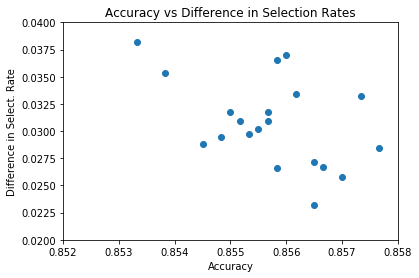

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

plt.scatter(accuracy_sweep, fairness_metrics)
plt.title('Accuracy vs Difference in Selection Rates')

#zoom into one of the clusters
plt.axis([0.852,0.858,0.02,0.04])
plt.xlabel('Accuracy')
plt.ylabel('Difference in Select. Rate')
plt.figure()
plt.show()

### Part d 

Now calculate the *pareto front*: go over each (accuracy, difference in selection rates) pair and compare it to every other pair. If you find the first pair to have lower accuracy and higher difference in selection rate, discard it.

In [14]:
#comparing indexes to every other for its condition for pareto front

fairness_pareto = copy.deepcopy(fairness_metrics)
accuracy_pareto = copy.deepcopy(accuracy_sweep)

x = 0
while x < len(fairness_pareto):
    found=False
    for y in range(len(fairness_pareto)):
        if ((fairness_pareto[x] > fairness_pareto[y]) and (accuracy_pareto[x] < accuracy_pareto[y])):
            fairness_pareto.pop(x)
            accuracy_pareto.pop(x)
            found=True
            break
    if not found:
        x=x+1
        

* Plot the accuracy vs difference in selection rates for all the models the grid search in a scatter plot.
* On the same plot, plot the accuracy vs difference in selection rates for the points on the pareto front. Make these points red.

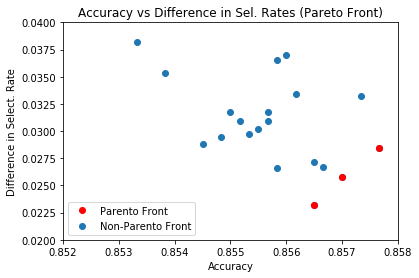

<Figure size 432x288 with 0 Axes>

In [17]:
#plot both scatters
plt.scatter(accuracy_sweep, fairness_metrics, label = 'Non-Parento Front')
plt.plot(accuracy_pareto, fairness_pareto, 'o', color='red', label = 'Parento Front')
plt.legend()
plt.axis([0.852,0.858,0.02,0.04])
plt.xlabel('Accuracy')
plt.ylabel('Difference in Select. Rate')
plt.title('Accuracy vs Difference in Sel. Rates (Pareto Front)')
plt.figure()
plt.show()

Which one of these models would you choose to use? Why?

Looking at the 4 models produced from the Pareto front, the model in the middle would probably be the best model as it has the best compromise between the difference in selection rate and accuracy. The point is about accuracy = 0.857 and difference in selection rate = 0.0250. It has the best tradeoff between difference in selection rate and accuracy of the Pareto Front.

## Problem 3

This problem builds on ideas from paper 2a in Module 1: “Against prediction: Sentencing, Policing, And Punishing In An Actuarial Age,” Chicago Public Law And Legal Theory Working Paper No. 94, Harcourt, 2005. 

Suppose we have two groups $A$ and $B$ of population sizes $n$ and $9n$. We find that under equal surveillance, group $A$’s offending rate is $2$ offenses per month per person and that of group $B$ is $1$ offense per person per month (See Figure on page 17 of the above paper). Equal surveillance means that out of a total of $10m$ monitors, $m$ monitors are assigned to group $A$ and $9m$ monitors are assigned to group $B$. The surveillance is $\frac{m}{n}$ per capita for both groups. So, under equal surveillance, the combined offending rate over both groups is $11n$ per month. 

Suppose we want to bring down the overall offending rate by increasing the monitors for group $A$. In order to do that we collected some data and found that we could model the rate of decrease in offenses for group $A$ by a function as follows:
	If we increase the per capita surveillance from $\frac{m}{n}$ to $\frac{m}{n} (1 + \delta_A)$, the offending rate declines to $2e^{- \alpha \delta_A}$. ($\alpha>0$)

Similarly, we modeled the rate of increase in offenses for group $B$ by a function under reduced surveillance as follows:
	If we decrease the per capita monitoring rate from $\frac{m}{n}$ to $\frac{m}{n} (1 - \delta_B)$, the offending rate rises to $e^{ \beta \delta_B}$. ($\beta>0$)

How would you distribute the monitors so that 

**a)** Both groups had the same offending rate?

**b)** The combined offending rate was minimized?


Consider 3 different scenarios when $\alpha > \beta$, $\alpha = \beta$, and $\alpha < \beta$. 

**c)** For each of the scenarios, which of the above solutions would you prefer and why?

**TIPS**:
- For **part a** and **part b**, answer by calculating $\delta_A$ and $\delta_B$.
- Try to set up equations from the given information. This problem mostly consists of algebra.
- If you do it correctly, **part c** should makes sense immediately.


A.) For same offending rate:

$2e^{- \alpha \delta_A}$ = $e^{ \beta \delta_B}$

ln() both sides:

$ln(2){ - \alpha \delta_A}$ = ${ \beta \delta_B}$

${\delta_B}$ = $\frac{ln(2)}{\beta}$ - $\frac{\alpha \delta_A}{\beta}$

Using:

$\frac{m}{n} (1 + \delta_A)(n)$ + $\frac{m}{n} (1 - \delta_B)(9n)$ = $10m$ total

Plug in ${\delta_B}$:

${m}(1 + \delta_A)$ + $ (1 - \frac{ln(2)}{\beta}$ - $\frac{\alpha \delta_A}{\beta})(9m)$ = $10m$ total

Therefore 

${\delta_A}$ = $\frac{9ln(2)}{\beta+9\alpha}$

and

${\delta_B}$ = $\frac{ln(2)}{\beta+9\alpha}$

B.) Minimize combined offending rate:

Combined offending amount:

$(n)2e^{- \alpha \delta_A}$ + $(9n)e^{ \beta \delta_B}$

plugging in ${\delta_A}$ = ${9\delta_b}$ and taking its derivative in respect to ${\delta_b}$

$-2{\alpha}e^{- 9\alpha \delta_B}$ + ${ \beta}e^{ \beta \delta_B}$

Setting to 0 to minimize:

$-2{\alpha}e^{- 9\alpha \delta_B}$ + ${ \beta}e^{ \beta \delta_B}$ = 0

$2{\alpha}e^{- 9\alpha \delta_B}$ = ${ \beta}e^{ \beta \delta_B}$

putting all ${ \beta \delta_B}$ values to one side

$\frac{2\alpha}{ \beta}$ = ${ \beta \delta_B}$ + ${9\alpha \delta_B}$

Therefore:

${\delta_B}$ = $\frac{ln(\frac{2\alpha}{\beta})}{\beta + 9\alpha}$

${\delta_B}$ = $\frac{ln(2) + ln(\frac{\alpha}{\beta})}{\beta + 9\alpha}$

and

${\delta_A}$ = $\frac{9ln(2) + 9ln(\frac{\alpha}{\beta})}{\beta + 9\alpha}$









C.)  if a = b:
In part a, they would be the same as they both would deltas be a constant. In part b, if a = b, ln(a/b) = ln(1), which would make both deltas constant again, making these solutions to preform similarily.

if a > b:
In part b, if a > b, ln(a/b) would be larger than zero, making the deltas eventually become larger than the deltas in part a. In this case, both deltas will continue to increase. However, since delta b is negative in monitering rate, (1-delta b) the monitering rate will go down and vice verse for monitering rate of A. In part a, alpha increase at a higher rate than beta, making both deltas decreiase as alpha increases over beta because both variables are in the denomiator. In this case, offending rate is minmized more in part a.

if b > a:
In part b, if a > b, ln(a/b) would be smaller than zero, making the deltas eventually become smaller than the deltas in part a. In this case, both deltas will continue to decrease. This will increase monitor rate in B, while decrease in a due to b's negativity (1-delta b). In part a, alpha increase at a higher rate than beta, making both deltas decrease slower as beta increases over alpha . In this case, offending rate is minmized more in part b.

In the case of fairness for all of these conditions, if the goal is to minimize offending rate, part a is better for a >b and part b is better in b > a. However, when a = b, it produces an equity between offending rates, which may be fairer

